## Imports

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import norm

import os
import glob

In [180]:
from google.colab import drive
drive.mount('/content/drive')

!ls -l /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total 4
drwx------ 80 root root 4096 Aug 18 12:57 MyDrive


In [181]:
#Q1: compléter le path

#read the path
#SUR GOOGLE
file_path = '/content/drive/MyDrive/style-extension/Analyses'

#list all the files from the directory
file_list = os.listdir(file_path)
file_list

['SYNTHESE.xlsx',
 'SYNTHESE.gsheet',
 'plan_analyses.gdoc',
 'Analyses.ipynb',
 'Analyses_stat.ipynb',
 'Analyses_A1_A2_UD-style.ipynb',
 'Copy of Dictionary Variables.gdoc',
 'Discussion.ipynb',
 'Analyses_B1_A2.ipynb',
 'Z-scores_auteur_auteur-genere.ipynb',
 'Analyses_A1_A2.ipynb',
 'Delta_styles.ipynb',
 'Analyses_A1_B1.ipynb',
 'Dispersion_moyenne.ipynb']

In [182]:
#read the path sur google
cwd = os.path.abspath(file_path)

extension = 'xlsx'
os.chdir(cwd)
csv_files = glob.glob('*.{}'.format('xlsx'))
print(csv_files)

['SYNTHESE.xlsx']


## Methods

In [183]:
def calculate_correlations_with_significance(difference_df_stylo, difference_df):
    correlation_results = {}
    p_value_symbole_results = {}
    p_value_results = {}

    for feature in difference_df_stylo["Feature"].unique():
        filtered_stylo_df = difference_df_stylo[difference_df_stylo["Feature"] == feature]

        # Calculate Pearson correlation and p-value
        correlation, p_value = pearsonr(filtered_stylo_df["Difference"], difference_df["Difference"])
        correlation_results[feature] = correlation
        p_value_results[feature] = p_value

        # Assign asterisk based on p-value significance
        if p_value < 0.01:
            p_value_symbole_results[feature] = '**'
        elif p_value < 0.05:
            p_value_symbole_results[feature] = '*'
        else:
            p_value_symbole_results[feature] = ''

    correlation_df = pd.DataFrame({
        'Feature': list(correlation_results.keys()),
        'Correlation': list(correlation_results.values()),
        'P-value_symbole': list(p_value_symbole_results.values()),  # Store significance asterisks
        'P-value': list(p_value_results.values()),
    })

    return correlation_df

In [184]:
def fisher_z(r):
  return 0.5 * np.log((1 + r) / (1 - r))

In [185]:
def compare_correlations(r1, n1, r2, n2):
  """
  r1, r2 : Fischer transformed correlations
  n1, n2 : sample size
  """
  z1 = fisher_z(r1)
  z2 = fisher_z(r2)
  se = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))
  z = np.abs(z1 - z2) / se
  p = 2 * (1 - norm.cdf(z)) # two-tailed
  return z, p
# Example usage:
# z_score, p_value = compare_correlations(0.65, 96, 0.45, 96)

In [186]:
def tost_compare_correlations_z(r1, n1, r2, n2, delta_z=0.01, alpha=0.05):
    """
    TOST equivalence test for two correlations (in Fisher z-space).

    Returns:
        p1, p2 : one-sided p-values
        equivalent : True if both p-values < alpha
    """
    z1 = fisher_z(r1)
    z2 = fisher_z(r2)
    diff = z1 - z2
    print(f"Difference in z-space: {diff:.3f}")
    se = np.sqrt(1 / (n1 - 3) + 1 / (n2 - 3))

    z_stat_low = (diff + delta_z) / se
    z_stat_high = (diff - delta_z) / se

    # CORRECTED: Flip these p-values
    p1 = 1 - norm.cdf(z_stat_low)  # test: diff > -delta
    p2 = norm.cdf(z_stat_high)     # test: diff < delta

    equivalent = (p1 < alpha) and (p2 < alpha)
    return p1, p2, equivalent

def r_to_z_delta(delta_r):
    r = 0.0  # center at 0 to be conservative
    r1 = min(max(r - delta_r, -0.9999), 0.9999)
    r2 = min(max(r + delta_r, -0.9999), 0.9999)
    return np.abs(fisher_z(r2) - fisher_z(r1))

# **FRENCH**

## Dataset

In [187]:
#read the path
#SUR GOOGLE
stylo_df_fr = pd.read_excel('/content/drive/MyDrive/style-extension/FRENCH/Résultats/terreau/stylo_df_grouped_fr_complet.xlsx')

In [188]:
stylo_df_A1_fr = stylo_df_fr[stylo_df_fr['author'] == "Tuffery"]

stylo_df_B1_fr = stylo_df_fr[stylo_df_fr['genAI'] == "No"]
stylo_df_B1_fr = stylo_df_B1_fr[stylo_df_B1_fr['author'] != "Tuffery"]

stylo_df_A1_B1_fr = pd.concat([stylo_df_A1_fr, stylo_df_B1_fr], axis=0)

stylo_df_A1_B1_fr = stylo_df_A1_B1_fr.rename(columns={"id": "file_name", "Unnamed: 0":"id"})
#stylo_df_A1_B1_fr = stylo_df_A1_B1_fr.drop(columns=["text_id", "Other Features", "id"])
#stylo_df_A1_B1_fr = stylo_df_A1_B1_fr.drop(columns=["text_id", "id"])

stylo_df_A1_B1_fr["class"] = stylo_df_A1_B1_fr["author"].map({"Tuffery": "A1", "Proust": "B1", "Celine": "B1", "Yourcenar":"B1"})

In [189]:
stylo_df_A1_B1_fr.head()

,id,author,genAI,Punctuation,TAG,Structural,Indexes,NER,Letters,text_id,file_name,class
960,960,Tuffery,No,0.019510,0.195833,8.794737,7.159736,0.083333,0.029505,0,tuffery_agitato_atrabile.txt,A1
961,961,Tuffery,No,0.011617,0.436869,22.038070,7.771713,0.454545,0.029591,1,tuffery_agitato_lamentabile.txt,A1
962,962,Tuffery,No,0.011944,0.407407,18.214147,6.612949,0.222222,0.028414,2,tuffery_anacephaleose.txt,A1
963,963,Tuffery,No,0.011217,0.200617,9.133420,6.714099,0.092593,0.028595,3,tuffery_anadiploses_epanadiploses.txt,A1
964,964,Tuffery,No,0.010989,1.333333,59.190000,5.093733,1.000000,0.031382,4,tuffery_anaphore.txt,A1


In [190]:
stylo_df = stylo_df_A1_B1_fr

In [191]:
mean_distances_df = pd.read_excel('/content/drive/MyDrive/style-extension/FRENCH/Résultats/terreau/distance_pertext_umap_A1_B1_FR_new.xlsx')

mean_distances_df["genAI"] = mean_distances_df["Class"].map({"Proust": "No", "Celine": "No", "Yourcenar": "No", "Tuffery": "No",
                                                             "Proust_mistral": "mistral", "Celine_mistral": "mistral", "Yourcenar_mistral": "mistral",
                                                             "Proust_gpt": "gpt", "Celine_gpt": "gpt", "Yourcenar_gpt": "gpt",
                                                             "Proust_gemini": "gemini", "Celine_gemini": "gemini", "Yourcenar_gemini": "gemini",
                                                             })

mean_distances_df["author"] = mean_distances_df["Class"].map({"Proust": "Proust", "Celine": "Celine", "Yourcenar": "Yourcenar","Tuffery": "Tuffery",
                                                             "Proust_mistral": "Proust", "Celine_mistral": "Celine", "Yourcenar_mistral": "Yourcenar",
                                                             "Proust_gpt": "Proust", "Celine_gpt": "Celine", "Yourcenar_gpt": "Yourcenar",
                                                             "Proust_gemini": "Proust", "Celine_gemini": "Celine", "Yourcenar_gemini": "Yourcenar",
                                                             })

mean_distances_df["class"] = mean_distances_df["author"].map({"Tuffery": "A1", "Proust": "B1", "Celine": "B1", "Yourcenar":"B1"})
mean_distances_df = mean_distances_df.drop(columns=["Class"])

In [192]:
mean_distances_df.head()

,Text_Index,Mean_Distance_From_Centroid,genAI,author,class
0,0,1.493536,No,Tuffery,A1
1,1,3.086941,No,Tuffery,A1
2,2,1.641952,No,Tuffery,A1
3,3,1.457144,No,Tuffery,A1
4,4,1.759076,No,Tuffery,A1


### Normalize and compute mean of features

In [193]:
#Normalize
numeric_cols = stylo_df.select_dtypes(include=['number']).columns  # Get numeric columns

for col in numeric_cols:
    stylo_df[f"{col}_normalized"] = (stylo_df[col] - stylo_df[col].min()) / (stylo_df[col].max() - stylo_df[col].min())

#Mean
columns_to_average = ["Structural_normalized",
                      "Letters_normalized",
                      "TAG_normalized",
                      "NER_normalized",
                      # "Punctuation_normalized",
                      # "Function words_normalized",
                       "Indexes_normalized",
                      # "Numbers_normalized"
                      ]
stylo_df["Mean"] = stylo_df[columns_to_average].mean(axis=1)

print(stylo_df.head())

      id   author genAI  Punctuation       TAG  Structural   Indexes  \
960  960  Tuffery    No     0.019510  0.195833    8.794737  7.159736   
961  961  Tuffery    No     0.011617  0.436869   22.038070  7.771713   
962  962  Tuffery    No     0.011944  0.407407   18.214147  6.612949   
963  963  Tuffery    No     0.011217  0.200617    9.133420  6.714099   
964  964  Tuffery    No     0.010989  1.333333   59.190000  5.093733   

          NER   Letters  text_id  ... class id_normalized  \
960  0.083333  0.029505        0  ...    A1      0.909953   
961  0.454545  0.029591        1  ...    A1      0.910900   
962  0.222222  0.028414        2  ...    A1      0.911848   
963  0.092593  0.028595        3  ...    A1      0.912796   
964  1.000000  0.031382        4  ...    A1      0.913744   

     Punctuation_normalized  TAG_normalized  Structural_normalized  \
960                0.285132        0.008303               0.011180   
961                0.169774        0.046557               0.

## Toutes features confondues, all authors : correlation, p-value

In [194]:
#### DISPERSION DELTA ANALYSIS FOR 2 COMPARISONS


## Humans vs genAI

# Dispersion delta
Tuffery_distances = mean_distances_df[mean_distances_df['author'] == 'Tuffery']['Mean_Distance_From_Centroid'].values
Authors_distances = mean_distances_df[mean_distances_df['author'] != 'Tuffery']['Mean_Distance_From_Centroid'].values

# List to store the results
difference_results = []

for i, ref_dist in enumerate(Tuffery_distances):
    for j, gen_dist in enumerate(Authors_distances):
        difference = ref_dist - gen_dist
        difference_results.append({
            'Tuffery_Index': i,
            'Authors_Index': j,
            'Difference': difference
        })

difference_df_cond1 = pd.DataFrame(difference_results)



In [195]:
# Style delta calculation

Tuffery_df = stylo_df[stylo_df['author'] == 'Tuffery']
Authors_df = stylo_df[stylo_df['author'] != 'Tuffery']

# List of stylistic features
# features = ['Function words', 'Letters', 'Numbers', 'TAG', 'NER', 'Structural', 'Punctuation', 'Indexes']
features = ['Mean']

# Initialize a list to store the results
difference_results_stylo = []

for feature in features:
    for i, ref_val in enumerate(Tuffery_df[feature].values):
        for j, gen_val in enumerate(Authors_df[feature].values):
            difference = ref_val - gen_val
            difference_results_stylo.append({
                'Feature': feature,
                'Tuffery_Index': i,
                'Authors_Index': j,
                'Difference': difference
            })

difference_df_stylo_cond1 = pd.DataFrame(difference_results_stylo)

In [196]:
correlation_df_cond1 = calculate_correlations_with_significance(difference_df_stylo_cond1, difference_df_cond1)

# correlation_df_cond1 = correlation_df_cond1.sort_values(by='Correlation_proust', ascending=False)
print(correlation_df_cond1.to_string())
print(correlation_df_cond1["Correlation"])

  Feature  Correlation P-value_symbole       P-value
0    Mean     0.057384              **  1.307735e-21
0    0.057384
Name: Correlation, dtype: float64


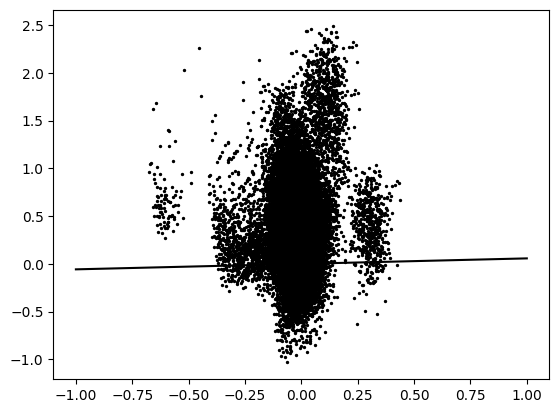

In [197]:
plt.figure()

plt.scatter(difference_df_stylo_cond1["Difference"], difference_df_cond1["Difference"], s=2, c='black')
plt.plot(np.linspace(-1, 1), np.linspace(-1, 1)*correlation_df_cond1["Correlation"].values, c="black")

plt.show()

## Toutes features confondues, per author : correlation, p-value

In [198]:
#### DISPERSION DELTA ANALYSIS FOR 2 COMPARISONS


## Humans vs genAI

# Dispersion delta
Tuffery_distances = mean_distances_df[mean_distances_df['author'] == 'Tuffery']['Mean_Distance_From_Centroid'].values

GenAI_distances = {}
difference_df_cond1 = {}

for auteur in ["Proust", "Celine", "Yourcenar"]:
    GenAI_distances[auteur] = mean_distances_df[mean_distances_df['author'] == auteur]['Mean_Distance_From_Centroid'].values
    # List to store the results
    difference_results = []

    for i, ref_dist in enumerate(Tuffery_distances):
        for j, gen_dist in enumerate(GenAI_distances[auteur]):
            difference = ref_dist - gen_dist
            difference_results.append({
                'Tuffery_Index': i,
                f'{auteur}_Index': j,
                'Difference': difference
            })

    difference_df_cond1[auteur] = pd.DataFrame(difference_results)



In [199]:
# Style delta calculation

Tuffery_df = stylo_df[stylo_df['author'] == 'Tuffery']

GenAI_stylo = {}
difference_df_stylo_cond1 = {}

# List of stylistic features
# features = ['Function words', 'Letters', 'Numbers', 'TAG', 'NER', 'Structural', 'Punctuation', 'Indexes']
features = ['Mean']

for auteur in ["Celine", "Proust", "Yourcenar"]:
    GenAI_stylo[auteur] = stylo_df[stylo_df['author'] == auteur]

    # List to store the results
    difference_results_stylo = []

    for feature in features:
        for i, ref_val in enumerate(Tuffery_df[feature].values):
            for j, gen_val in enumerate(GenAI_stylo[auteur][feature].values):
                difference = ref_val - gen_val
                difference_results_stylo.append({
                    'Feature': feature,
                    'Mistral_Index': i,
                    f'{auteur}_Index': j,
                    'Difference': difference
                })
    difference_df_stylo_cond1[auteur] = pd.DataFrame(difference_results_stylo)


In [200]:
for auteur in ["Celine", "Proust", "Yourcenar"]:

    correlation_df_cond1 = calculate_correlations_with_significance(difference_df_stylo_cond1[auteur], difference_df_cond1[auteur])

    print(f"{auteur}")
    print(correlation_df_cond1.to_string())

Celine
  Feature  Correlation P-value_symbole       P-value
0    Mean     0.159404              **  1.656137e-53
Proust
  Feature  Correlation P-value_symbole       P-value
0    Mean     0.186075              **  1.399222e-72
Yourcenar
  Feature  Correlation P-value_symbole       P-value
0    Mean     0.086404              **  9.637181e-17


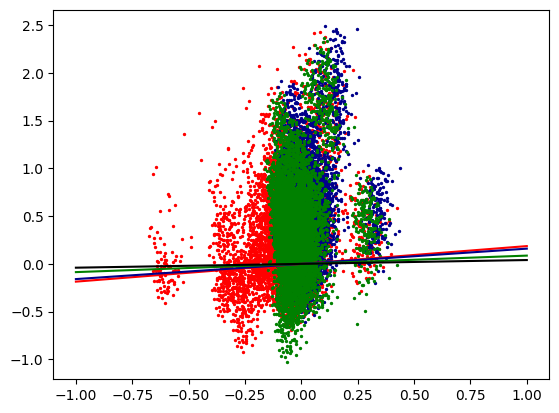

In [201]:
plt.figure()
i = 0
colors = ['red', 'darkblue', 'green']

for auteur in ['Proust', 'Celine', 'Yourcenar']:
    plt.scatter(difference_df_stylo_cond1[auteur]["Difference"], difference_df_cond1[auteur]["Difference"], s=2, c=colors[i])
    correlation_df_cond1 = calculate_correlations_with_significance(difference_df_stylo_cond1[auteur], difference_df_cond1[auteur])

    plt.plot(np.linspace(-1, 1), np.linspace(-1, 1)*correlation_df_cond1["Correlation"].values, c=colors[i])
    i += 1

plt.plot(np.linspace(-1, 1), np.linspace(-1, 1)*0.04, c="black")

# plt.ylim(-1, 1)
plt.show()

In [202]:
difference_df_stylo_cond1

{'Celine':      Feature  Mistral_Index  Celine_Index  Difference
 0       Mean              0             0    0.002179
 1       Mean              0             1   -0.043068
 2       Mean              0             2    0.005371
 3       Mean              0             3    0.022765
 4       Mean              0             4   -0.001765
 ...      ...            ...           ...         ...
 9211    Mean             95            91   -0.020697
 9212    Mean             95            92    0.040760
 9213    Mean             95            93   -0.031354
 9214    Mean             95            94   -0.004503
 9215    Mean             95            95    0.009245
 
 [9216 rows x 4 columns],
 'Proust':      Feature  Mistral_Index  Proust_Index  Difference
 0       Mean              0             0   -0.001799
 1       Mean              0             1    0.014087
 2       Mean              0             2   -0.238098
 3       Mean              0             3   -0.064856
 4       Mean    

### Z-test : correlations différentes deux à deux

In [203]:
## Testing if the correlations are significatively different
correlation_proust = calculate_correlations_with_significance(difference_df_stylo_cond1["Proust"], difference_df_cond1["Proust"])['Correlation'].values[0]
correlation_celine = calculate_correlations_with_significance(difference_df_stylo_cond1["Celine"], difference_df_cond1["Celine"])['Correlation'].values[0]
coorelation_yourcenar = calculate_correlations_with_significance(difference_df_stylo_cond1["Yourcenar"], difference_df_cond1["Yourcenar"])['Correlation'].values[0]


print("Entre Proust et Celine : ")

for row in correlation_df_cond1.iterrows():
  feature = row[1]['Feature']
  z_score, p_value = compare_correlations(correlation_proust, 96 , correlation_celine, 96 )
  if len(feature) > 4:
    print(f"{feature} \t z = {z_score:.4f} \t p = {p_value:.6f}")
  else:
    print(f"{feature} \t \t z = {z_score:.4f} \t p = {p_value:.2e}")

print("\nEntre Proust et Yourcenar : ")

for row in correlation_df_cond1.iterrows():
  feature = row[1]['Feature']
  z_score, p_value = compare_correlations(correlation_proust, 96 , coorelation_yourcenar, 96 )
  if len(feature) > 4:
    print(f"{feature} \t z = {z_score:.4f} \t p = {p_value:.6f}")
  else:
    print(f"{feature} \t \t z = {z_score:.4f} \t p = {p_value:.2e}")

print("\nEntre Celine et Yourcenar : ")

for row in correlation_df_cond1.iterrows():
  feature = row[1]['Feature']
  z_score, p_value = compare_correlations(correlation_celine, 96 , coorelation_yourcenar, 96 )
  if len(feature) > 4:
    print(f"{feature} \t z = {z_score:.4f} \t p = {p_value:.6f}")
  else:
    print(f"{feature} \t \t z = {z_score:.4f} \t p = {p_value:.2e}")


Entre Proust et Celine : 
Mean 	 	 z = 0.1875 	 p = 8.51e-01

Entre Proust et Yourcenar : 
Mean 	 	 z = 0.6931 	 p = 4.88e-01

Entre Celine et Yourcenar : 
Mean 	 	 z = 0.5057 	 p = 6.13e-01


In [204]:
## Testing if the correlations are significatively different
correlation_proust = calculate_correlations_with_significance(difference_df_stylo_cond1["Proust"], difference_df_cond1["Proust"])['Correlation'].values[0]
correlation_celine = calculate_correlations_with_significance(difference_df_stylo_cond1["Celine"], difference_df_cond1["Celine"])['Correlation'].values[0]
correlation_yourcenar = calculate_correlations_with_significance(difference_df_stylo_cond1["Yourcenar"], difference_df_cond1["Yourcenar"])['Correlation'].values[0]

from scipy import stats

print("Entre Proust et Celine : ")

for row in correlation_df_cond1.iterrows():
  feature = row[1]['Feature']
  #z_score, p_value = compare_correlations(correlation_proust, 96 , correlation_celine, 96 )
  t_stat, p_value = stats.ttest_ind(difference_df_stylo_cond1['Proust']["Difference"], difference_df_stylo_cond1['Celine']["Difference"], equal_var=False)

  if len(feature) > 4:
    print(f"{feature} \t t = {t_stat:.4f} \t p = {p_value:.6f}")
  else:
    print(f"{feature} \t \t t = {t_stat:.4f} \t p = {p_value:.2e}")

print("\nEntre Proust et Yourcenar : ")

for row in correlation_df_cond1.iterrows():
  feature = row[1]['Feature']
  #z_score, p_value = compare_correlations(correlation_proust, 96 , coorelation_yourcenar, 96 )
  t_stat, p_value = stats.ttest_ind(difference_df_stylo_cond1['Proust']["Difference"], difference_df_stylo_cond1['Yourcenar']["Difference"], equal_var=False)
  if len(feature) > 4:
    print(f"{feature} \t t = {t_stat:.4f} \t p = {p_value:.6f}")
  else:
    print(f"{feature} \t \t t = {t_stat:.4f} \t p = {p_value:.2e}")

print("\nEntre Celine et Yourcenar : ")

for row in correlation_df_cond1.iterrows():
  feature = row[1]['Feature']
  t_stat, p_value = stats.ttest_ind(difference_df_stylo_cond1['Celine']["Difference"], difference_df_stylo_cond1["Yourcenar"]["Difference"], equal_var=False)
  #z_score, p_value = compare_correlations(correlation_celine, 96 , coorelation_yourcenar, 96 )
  if len(feature) > 4:
    print(f"{feature} \t t = {t_stat:.4f} \t p = {p_value:.6f}")
  else:
    print(f"{feature} \t \t t = {t_stat:.4f} \t p = {p_value:.2e}")

Entre Proust et Celine : 
Mean 	 	 t = -56.7557 	 p = 0.00e+00

Entre Proust et Yourcenar : 
Mean 	 	 t = -27.8025 	 p = 5.77e-166

Entre Celine et Yourcenar : 
Mean 	 	 t = 39.6113 	 p = 0.00e+00


ANOVA

In [205]:
m = (
    stylo_df
    .melt(id_vars='author', value_vars=features,
          var_name='feature', value_name='value')
)
m['value_cf'] = m['value'] - m.groupby('feature')['value'].transform('mean')

model_cf = ols('value_cf ~ C(author)', data=m).fit()
anova_tbl_cf = sm.stats.anova_lm(model_cf, typ=2)
print(anova_tbl_cf)

tukey_cf = pairwise_tukeyhsd(endog=m['value_cf'], groups=m['author'], alpha=0.05)
print(tukey_cf)


             sum_sq     df          F        PR(>F)
C(author)  0.348193    3.0  30.790136  7.728408e-18
Residual   1.432423  380.0        NaN           NaN
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
 Celine    Proust   0.0797    0.0  0.0568  0.1025   True
 Celine   Tuffery   0.0155 0.2978 -0.0073  0.0384  False
 Celine Yourcenar   0.0406    0.0  0.0177  0.0634   True
 Proust   Tuffery  -0.0641    0.0  -0.087 -0.0413   True
 Proust Yourcenar  -0.0391 0.0001  -0.062 -0.0162   True
Tuffery Yourcenar    0.025 0.0255  0.0022  0.0479   True
--------------------------------------------------------


## t test sur les features direct

In [206]:
## Testing if the correlations are significatively different
##correlation_proust = calculate_correlations_with_significance(difference_df_stylo_cond1["Proust"], difference_df_cond1["Proust"])['Correlation'].values[0]
#correlation_celine = calculate_correlations_with_significance(difference_df_stylo_cond1["Celine"], difference_df_cond1["Celine"])['Correlation'].values[0]
#correlation_yourcenar = calculate_correlations_with_significance(difference_df_stylo_cond1["Yourcenar"], difference_df_cond1["Yourcenar"])['Correlation'].values[0]

for author_1 in ["Tuffery", "Proust",  "Celine", "Yourcenar"]:
  for author_2 in ["Tuffery",  "Proust", "Celine",  "Yourcenar"]:
    if author_1 != author_2:
      print(f"Entre {author_1} et {author_2} : ")

      for row in correlation_df_cond1.iterrows():
        feature = row[1]['Feature']
  #z_score, p_value = compare_correlations(correlation_proust, 96 , correlation_celine, 96 )
        t_stat, p_value = stats.ttest_ind(stylo_df[stylo_df["author"]==author_1]["Mean"], stylo_df[stylo_df["author"]==author_2]["Mean"], equal_var=False)

        if len(feature) > 4:
          print(f"{feature} \t t = {t_stat:.4f} \t p = {p_value:.6f}")
        else:
          print(f"{feature} \t \t t = {t_stat:.4f} \t p = {p_value:.2e}")

Entre Tuffery et Proust : 
Mean 	 	 t = -5.4086 	 p = 2.21e-07
Entre Tuffery et Celine : 
Mean 	 	 t = 2.1855 	 p = 3.07e-02
Entre Tuffery et Yourcenar : 
Mean 	 	 t = -3.4978 	 p = 6.40e-04
Entre Proust et Tuffery : 
Mean 	 	 t = 5.4086 	 p = 2.21e-07
Entre Proust et Celine : 
Mean 	 	 t = 7.7462 	 p = 5.00e-12
Entre Proust et Yourcenar : 
Mean 	 	 t = 3.7889 	 p = 2.46e-04
Entre Celine et Tuffery : 
Mean 	 	 t = -2.1855 	 p = 3.07e-02
Entre Celine et Proust : 
Mean 	 	 t = -7.7462 	 p = 5.00e-12
Entre Celine et Yourcenar : 
Mean 	 	 t = -10.0184 	 p = 3.13e-19
Entre Yourcenar et Tuffery : 
Mean 	 	 t = 3.4978 	 p = 6.40e-04
Entre Yourcenar et Proust : 
Mean 	 	 t = -3.7889 	 p = 2.46e-04
Entre Yourcenar et Celine : 
Mean 	 	 t = 10.0184 	 p = 3.13e-19


In [207]:
## Testing if the correlations are significatively different
##correlation_proust = calculate_correlations_with_significance(difference_df_stylo_cond1["Proust"], difference_df_cond1["Proust"])['Correlation'].values[0]
#correlation_celine = calculate_correlations_with_significance(difference_df_stylo_cond1["Celine"], difference_df_cond1["Celine"])['Correlation'].values[0]
#correlation_yourcenar = calculate_correlations_with_significance(difference_df_stylo_cond1["Yourcenar"], difference_df_cond1["Yourcenar"])['Correlation'].values[0]

for author_1 in ["Tuffery", "Proust",  "Celine", "Yourcenar"]:
  for author_2 in ["Proust", "Celine",  "Yourcenar"]:
    if author_1 != author_2:
      print(f"Entre {author_1} et {author_2} :")
      for feature in ["TAG", "NER", "Letters", "Structural", "Indexes"]:


        for row in correlation_df_cond1.iterrows():

  #z_score, p_value = compare_correlations(correlation_proust, 96 , correlation_celine, 96 )
          t_stat, p_value = stats.ttest_ind(stylo_df[stylo_df["author"]==author_1][feature], stylo_df[stylo_df["author"]==author_2][feature], equal_var=False)

          if len(feature) > 4:
            print(f"\t {feature} \t t = {t_stat:.4f} \t p = {p_value:.2e}")
          else:
            print(f"\t {feature} \t \t t = {t_stat:.4f} \t p = {p_value:.2e}")

Entre Tuffery et Proust :
	 TAG 	 	 t = -4.4119 	 p = 1.82e-05
	 NER 	 	 t = -6.3631 	 p = 3.32e-09
	 Letters 	 t = 2.3214 	 p = 2.15e-02
	 Structural 	 t = -5.4100 	 p = 2.69e-07
	 Indexes 	 t = -2.5340 	 p = 1.22e-02
Entre Tuffery et Celine :
	 TAG 	 	 t = 2.1190 	 p = 3.65e-02
	 NER 	 	 t = 0.5733 	 p = 5.67e-01
	 Letters 	 t = 2.1348 	 p = 3.41e-02
	 Structural 	 t = 2.5925 	 p = 1.09e-02
	 Indexes 	 t = -0.2656 	 p = 7.91e-01
Entre Tuffery et Yourcenar :
	 TAG 	 	 t = 1.2992 	 p = 1.97e-01
	 NER 	 	 t = -3.4418 	 p = 7.63e-04
	 Letters 	 t = 0.6845 	 p = 4.95e-01
	 Structural 	 t = -0.4603 	 p = 6.46e-01
	 Indexes 	 t = -5.8515 	 p = 3.18e-08
Entre Proust et Celine :
	 TAG 	 	 t = 6.8155 	 p = 7.60e-10
	 NER 	 	 t = 7.0121 	 p = 2.60e-10
	 Letters 	 t = -0.0242 	 p = 9.81e-01
	 Structural 	 t = 7.3001 	 p = 7.82e-11
	 Indexes 	 t = 3.4287 	 p = 7.63e-04
Entre Proust et Yourcenar :
	 TAG 	 	 t = 6.2447 	 p = 1.10e-08
	 NER 	 	 t = 5.1909 	 p = 1.06e-06
	 Letters 	 t = -2.2206 	 p =

## Per feature, per author : correlation, p-value

In [208]:
#### DISPERSION DELTA ANALYSIS FOR 2 COMPARISONS


## Humans vs genAI

# Dispersion delta
Tuffery_distances = mean_distances_df[mean_distances_df['author'] == 'Tuffery']['Mean_Distance_From_Centroid'].values

GenAI_distances = {}
difference_df_cond1 = {}


for auteur in ["Proust", "Celine", "Yourcenar"]:
    GenAI_distances[auteur] = mean_distances_df[mean_distances_df['author'] == auteur]['Mean_Distance_From_Centroid'].values

    # List to store the results
    difference_results = []

    for i, ref_dist in enumerate(Tuffery_distances):
        for j, gen_dist in enumerate(GenAI_distances[auteur]):
            difference = ref_dist - gen_dist
            difference_results.append({
                'Tuffery_Index': i,
                f'{auteur}_Index': j,
                'Difference': difference
            })

    difference_df_cond1[auteur] = pd.DataFrame(difference_results)



In [209]:
# Style delta calculation

Tuffery_df = stylo_df[stylo_df['author'] == 'Tuffery']

GenAI_stylo = {}
difference_df_stylo_cond1 = {}

# List of stylistic features
#features = ['Function words', 'Letters', 'Numbers', 'TAG', 'NER', 'Structural', 'Punctuation', 'Indexes']
features = ['Letters', 'TAG', 'NER', 'Structural', 'Indexes']
# features = ['Mean']

for auteur in ["Proust", "Celine", "Yourcenar"]:
    GenAI_stylo[auteur] = stylo_df[stylo_df['author'] == auteur]

    # List to store the results
    difference_results_stylo = []

    for feature in features:
        for i, ref_val in enumerate(Tuffery_df[feature].values):
            for j, gen_val in enumerate(GenAI_stylo[auteur][feature].values):
                difference = ref_val - gen_val
                difference_results_stylo.append({
                    'Feature': feature,
                    'Mistral_Index': i,
                    f'{auteur}_Index': j,
                    'Difference': difference
                })
    difference_df_stylo_cond1[auteur] = pd.DataFrame(difference_results_stylo)

In [210]:
for auteur in ["Proust", "Celine", "Yourcenar"]:

    correlation_df_cond1 = calculate_correlations_with_significance(difference_df_stylo_cond1[auteur], difference_df_cond1[auteur])

    print(f"{auteur}")
    print(correlation_df_cond1.to_string())

Proust
      Feature  Correlation P-value_symbole       P-value
0     Letters     0.162653              **  1.149980e-55
1         TAG     0.127352              **  1.246612e-34
2         NER     0.195370              **  5.789288e-80
3  Structural     0.135972              **  2.793552e-39
4     Indexes     0.013114                  2.081026e-01
Celine
      Feature  Correlation P-value_symbole       P-value
0     Letters     0.161415              **  7.736992e-55
1         TAG     0.004683                  6.530689e-01
2         NER     0.132148              **  3.528125e-37
3  Structural     0.011195                  2.825510e-01
4     Indexes     0.104475              **  8.666099e-24
Yourcenar
      Feature  Correlation P-value_symbole       P-value
0     Letters     0.055860              **  8.049916e-08
1         TAG    -0.004307                  6.793163e-01
2         NER     0.212397              **  1.703754e-94
3  Structural    -0.004648                  6.554719e-01
4     I

### To latex

In [211]:
Proust = calculate_correlations_with_significance(difference_df_stylo_cond1['Proust'], difference_df_cond1['Proust'])
Celine = calculate_correlations_with_significance(difference_df_stylo_cond1['Celine'], difference_df_cond1['Celine'])
Yourcenar = calculate_correlations_with_significance(difference_df_stylo_cond1['Yourcenar'], difference_df_cond1['Yourcenar'])



# Standard list of features (in desired order)
features = ['Letters', 'TAG', 'NER', 'Structural']

# Ensure each dataframe is indexed by 'Feature' for easy lookup
Proust.set_index('Feature', inplace=True)
Celine.set_index('Feature', inplace=True)
Yourcenar.set_index('Feature', inplace=True)

# Start LaTeX table
latex = []
latex.append(r" & \multicolumn{2}{|c|}{Proust} & \multicolumn{2}{|c|}{Celine} & \multicolumn{2}{|c|}{Yourcenar} \\")
latex.append(r"\hline")
latex.append(r"Feature & Correlation & P-value & Correlation & P-value & Correlation & P-value  \\")
latex.append(r"\hline")

# Populate rows
for feature in features:
    row = [feature]
    for df in [Proust, Celine, Yourcenar]:
        corr = df.loc[feature, 'Correlation'] if feature in df.index else ''
        pval = df.loc[feature, 'P-value'] if feature in df.index else ''
        psymb= df.loc[feature, 'P-value_symbole'] if feature in df.index else ''
        row.extend([f"{corr:.4f}", f"{pval:.1e} ({psymb})"])
    latex.append(" & ".join(row) + r" \\")  # row end
latex.append(r"\hline")

# Join and print LaTeX code
latex_table = "\n".join(latex)
print(latex_table)

 & \multicolumn{2}{|c|}{Proust} & \multicolumn{2}{|c|}{Celine} & \multicolumn{2}{|c|}{Yourcenar} \\
\hline
Feature & Correlation & P-value & Correlation & P-value & Correlation & P-value  \\
\hline
Letters & 0.1627 & 1.1e-55 (**) & 0.1614 & 7.7e-55 (**) & 0.0559 & 8.0e-08 (**) \\
TAG & 0.1274 & 1.2e-34 (**) & 0.0047 & 6.5e-01 () & -0.0043 & 6.8e-01 () \\
NER & 0.1954 & 5.8e-80 (**) & 0.1321 & 3.5e-37 (**) & 0.2124 & 1.7e-94 (**) \\
Structural & 0.1360 & 2.8e-39 (**) & 0.0112 & 2.8e-01 () & -0.0046 & 6.6e-01 () \\
\hline


## Plot

In [212]:
# print(stylo_df.head())
grouped = stylo_df.groupby('author')[['Structural_normalized', 'Letters_normalized', 'TAG_normalized', 'NER_normalized', 'Indexes_normalized']].mean()
print(grouped)

           Structural_normalized  Letters_normalized  TAG_normalized  \
author                                                                 
Celine                  0.032130            0.252227        0.032347   
Proust                  0.154980            0.251919        0.143150   
Tuffery                 0.054095            0.284825        0.056540   
Yourcenar               0.058004            0.275529        0.041741   

           NER_normalized  Indexes_normalized  
author                                         
Celine           0.040569            0.474654  
Proust           0.155766            0.524524  
Tuffery          0.044785            0.469363  
Yourcenar        0.070331            0.589203  


In [213]:
features = ['Structural_normalized', 'Letters_normalized',
            'TAG_normalized', 'NER_normalized', 'Indexes_normalized']

# Melt into long format
m = stylo_df.melt(
    id_vars='author',
    value_vars=features,
    var_name='feature',
    value_name='value'
)

# Compute the pooled mean per author across all features
overall_mean = m.groupby('author')['value'].mean()

print(overall_mean)


author
Celine       0.166385
Proust       0.246068
Tuffery      0.181922
Yourcenar    0.206961
Name: value, dtype: float64


In [214]:
import pandas as pd
from scipy import stats
from itertools import combinations

features = ['Structural_normalized', 'Letters_normalized', 'TAG_normalized', 'NER_normalized', 'Indexes_normalized']

long_df = stylo_df.melt(
    id_vars='author',
    value_vars=features,
    var_name='feature',
    value_name='value'
)

In [215]:
np.mean([0.058004, 0.275529, 0.041741, 0.070331, 0.589203])

np.float64(0.2069616)

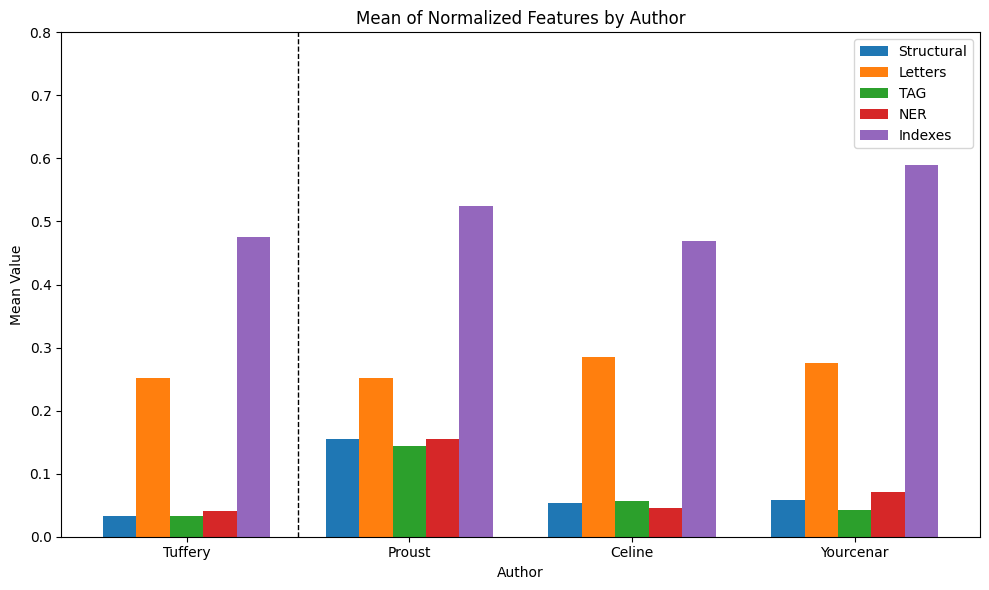

In [216]:
authors = ['Tuffery', 'Proust', 'Celine', 'Yourcenar']
columns = grouped.columns.tolist()
x = np.arange(len(authors))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

for i, col in enumerate(columns):
    ax.bar(x + i * width, grouped[col], width, label=col[:-11])

ax.set_xlabel('Author')
ax.set_ylabel('Mean Value')
ax.set_title('Mean of Normalized Features by Author')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(authors)
ax.set_ylim(-0.0, 0.8)
ax.legend()

plt.tight_layout()

ax.axvline(x=0.5 + width * 2, color='black', linestyle='--', linewidth=1)


#  # vertical position of lines under x-axis
# for i, col in enumerate(columns):
#     x_start = x[0] + i * width  # first group (left bar)
#     y_line = - 0.5 - x[0] + i*0.15
#     for j in range(1, len(authors)):  # next groups
#         x_end = x[j] + i * width
#         y_author = y_line - j*0.05
#         # Draw the line
#         ax.plot([x_start, x_end], [y_author, y_author], color='gray', linestyle=':')
#         ax.plot([x_end, x_end], [y_author, -0.02], color='gray', linestyle=':')

#             # Example value: difference between bar heights
#         label = "t-test"

#         # Midpoint for text
#         x_mid = (x_start + x_end) / 2
#         ax.text(x_mid, y_author - 0.01, label, ha='center', va='top', fontsize=8, rotation=0)
#     ax.plot([x_start, x_start], [y_author, -0.02], color='gray', linestyle=':')


plt.show()

# **ENGLISH**

## Dataset

In [217]:
#read the path
#SUR GOOGLE
stylo_df_en = pd.read_excel('/content/drive/MyDrive/style-extension/ENGLISH/Results/terreau/stylo_df_grouped_en_complet.xlsx')

In [218]:
stylo_df_A1_en = stylo_df_en[stylo_df_en['author'] == "Tuffery"]

stylo_df_B1_en = stylo_df_en[stylo_df_en['genAI'] == "No"]
stylo_df_B1_en = stylo_df_B1_en[stylo_df_B1_en['author'] != "Tuffery"]

stylo_df_A1_B1_en = pd.concat([stylo_df_A1_en, stylo_df_B1_en], axis=0)

stylo_df_A1_B1_en = stylo_df_A1_B1_en.rename(columns={"id": "file_name", "Unnamed: 0":"id"})
stylo_df_A1_B1_en = stylo_df_A1_B1_en.drop(columns=["text_id", "Other Features", "id"])

stylo_df_A1_B1_en["class"] = stylo_df_A1_B1_en["author"].map({"Tuffery": "A1", "Proust": "B1", "Celine": "B1", "Yourcenar":"B1"})

In [219]:
stylo_df_A1_B1_en.head()

,author,Punctuation,Structural,Letters,Indexes,NER,TAG,Numbers,Function words,genAI,file_name,class
1152,Tuffery,0.004108,2.764800,0.034952,274.636944,0.000000,0.169377,0.000000,0.294118,No,agitato_atrabile.txt,A1
1153,Tuffery,0.002243,5.010425,0.032696,402.232986,0.038462,0.344017,0.090959,0.268939,No,agitato_lamentabile.txt,A1
1154,Tuffery,0.002404,5.316429,0.034831,488.201647,0.000000,0.925926,0.000000,0.264205,No,anacephaleose.txt,A1
1155,Tuffery,0.003169,2.894953,0.033741,404.537361,0.000000,0.343137,0.091079,0.296954,No,anadiploses_epanadiploses.txt,A1
1156,Tuffery,0.001696,14.465535,0.035282,486.152416,0.000000,1.722222,0.000000,0.307292,No,anaphore.txt,A1


In [220]:
stylo_df = stylo_df_A1_B1_en

In [221]:
mean_distances_df = pd.read_excel('/content/drive/MyDrive/style-extension/ENGLISH/Results/terreau/distance_pertext_umap_A1_B1_EN.xlsx')

mean_distances_df["genAI"] = mean_distances_df["Class"].map({"Proust": "No", "Celine": "No", "Yourcenar": "No", "Tuffery": "No",
                                                             "Proust_mistral": "mistral", "Celine_mistral": "mistral", "Yourcenar_mistral": "mistral",
                                                             "Proust_gpt": "gpt", "Celine_gpt": "gpt", "Yourcenar_gpt": "gpt",
                                                             "Proust_gemini": "gemini", "Celine_gemini": "gemini", "Yourcenar_gemini": "gemini",
                                                             })

mean_distances_df["author"] = mean_distances_df["Class"].map({"Proust": "Proust", "Celine": "Celine", "Yourcenar": "Yourcenar","Tuffery": "Tuffery",
                                                             "Proust_mistral": "Proust", "Celine_mistral": "Celine", "Yourcenar_mistral": "Yourcenar",
                                                             "Proust_gpt": "Proust", "Celine_gpt": "Celine", "Yourcenar_gpt": "Yourcenar",
                                                             "Proust_gemini": "Proust", "Celine_gemini": "Celine", "Yourcenar_gemini": "Yourcenar",
                                                             })

mean_distances_df["class"] = mean_distances_df["author"].map({"Tuffery": "A1", "Proust": "B1", "Celine": "B1", "Yourcenar":"B1"})
mean_distances_df = mean_distances_df.drop(columns=["Class"])

In [222]:
mean_distances_df.head()

,Text_Index,Mean_Distance_From_Centroid,genAI,author,class
0,0,1.045539,No,Tuffery,A1
1,1,5.950097,No,Tuffery,A1
2,2,1.072538,No,Tuffery,A1
3,3,1.054102,No,Tuffery,A1
4,4,1.446316,No,Tuffery,A1


### Normalize and compute mean of features

In [223]:
#Normalize
numeric_cols = stylo_df.select_dtypes(include=['number']).columns  # Get numeric columns

for col in numeric_cols:
    stylo_df[f"{col}_normalized"] = (stylo_df[col] - stylo_df[col].min()) / (stylo_df[col].max() - stylo_df[col].min())

#Mean
columns_to_average = ["Structural_normalized",
                      "Letters_normalized",
                      "TAG_normalized",
                      "NER_normalized",
                      "Punctuation_normalized",
                      "Function words_normalized",
                      "Indexes_normalized",
                      #"Numbers_normalized"
                      ]
stylo_df["Mean"] = stylo_df[columns_to_average].mean(axis=1)

print(stylo_df.head())

       author  Punctuation  Structural   Letters     Indexes       NER  \
1152  Tuffery     0.004108    2.764800  0.034952  274.636944  0.000000   
1153  Tuffery     0.002243    5.010425  0.032696  402.232986  0.038462   
1154  Tuffery     0.002404    5.316429  0.034831  488.201647  0.000000   
1155  Tuffery     0.003169    2.894953  0.033741  404.537361  0.000000   
1156  Tuffery     0.001696   14.465535  0.035282  486.152416  0.000000   

           TAG   Numbers  Function words genAI  ... class  \
1152  0.169377  0.000000        0.294118    No  ...    A1   
1153  0.344017  0.090959        0.268939    No  ...    A1   
1154  0.925926  0.000000        0.264205    No  ...    A1   
1155  0.343137  0.091079        0.296954    No  ...    A1   
1156  1.722222  0.000000        0.307292    No  ...    A1   

     Punctuation_normalized  Structural_normalized  Letters_normalized  \
1152               0.383434               0.019946            0.484929   
1153               0.177950             

## Toutes features confondues, all authors : correlation, p-value

In [224]:
#### DISPERSION DELTA ANALYSIS FOR 2 COMPARISONS


## Humans vs genAI

# Dispersion delta
Tuffery_distances = mean_distances_df[mean_distances_df['author'] == 'Tuffery']['Mean_Distance_From_Centroid'].values
Authors_distances = mean_distances_df[mean_distances_df['author'] != 'Tuffery']['Mean_Distance_From_Centroid'].values

# List to store the results
difference_results = []

for i, ref_dist in enumerate(Tuffery_distances):
    for j, gen_dist in enumerate(Authors_distances):
        difference = ref_dist - gen_dist
        difference_results.append({
            'Tuffery_Index': i,
            'Authors_Index': j,
            'Difference': difference
        })

difference_df_cond1 = pd.DataFrame(difference_results)

In [225]:
# Style delta calculation

Tuffery_df = stylo_df[stylo_df['author'] == 'Tuffery']
Authors_df = stylo_df[stylo_df['author'] != 'Tuffery']

# List of stylistic features
# features = ['Function words', 'Letters', 'Numbers', 'TAG', 'NER', 'Structural', 'Punctuation', 'Indexes']
features = ['Mean']

# Initialize a list to store the results
difference_results_stylo = []

for feature in features:
    for i, ref_val in enumerate(Tuffery_df[feature].values):
        for j, gen_val in enumerate(Authors_df[feature].values):
            difference = ref_val - gen_val
            difference_results_stylo.append({
                'Feature': feature,
                'Mistral_Index': i,
                'Authors_Index': j,
                'Difference': difference
            })

difference_df_stylo_cond1 = pd.DataFrame(difference_results_stylo)

In [226]:
correlation_df_cond1 = calculate_correlations_with_significance(difference_df_stylo_cond1, difference_df_cond1)

# correlation_df_cond1 = correlation_df_cond1.sort_values(by='Correlation_proust', ascending=False)
print(correlation_df_cond1.to_string())

  Feature  Correlation P-value_symbole   P-value
0    Mean    -0.028486              **  0.000002


## Toutes features confondues, per author : correlation, p-value

In [227]:
#### DISPERSION DELTA ANALYSIS FOR 2 COMPARISONS


## Humans vs genAI

# Dispersion delta
Tuffery_distances = mean_distances_df[mean_distances_df['author'] == 'Tuffery']['Mean_Distance_From_Centroid'].values

GenAI_distances = {}
difference_df_cond1 = {}

for auteur in ["Proust", "Celine", "Yourcenar"]:
    GenAI_distances[auteur] = mean_distances_df[mean_distances_df['author'] == auteur]['Mean_Distance_From_Centroid'].values

    # List to store the results
    difference_results = []

    for i, ref_dist in enumerate(Tuffery_distances):
        for j, gen_dist in enumerate(GenAI_distances[auteur]):
            difference = ref_dist - gen_dist
            difference_results.append({
                'Tuffery_Index': i,
                f'{auteur}_Index': j,
                'Difference': difference
            })

    difference_df_cond1[auteur] = pd.DataFrame(difference_results)

In [228]:
# Style delta calculation

Tuffery_df = stylo_df[stylo_df['author'] == 'Tuffery']

GenAI_stylo = {}
difference_df_stylo_cond1 = {}

# List of stylistic features
# features = ['Function words', 'Letters', 'Numbers', 'TAG', 'NER', 'Structural', 'Punctuation', 'Indexes']
features = ['Mean']

for auteur in ["Proust", "Celine", "Yourcenar"]:
    GenAI_stylo[auteur] = stylo_df[stylo_df['author'] == auteur]

    # List to store the results
    difference_results_stylo = []

    for feature in features:
        for i, ref_val in enumerate(Tuffery_df[feature].values):
            for j, gen_val in enumerate(GenAI_stylo[auteur][feature].values):
                difference = ref_val - gen_val
                difference_results_stylo.append({
                    'Feature': feature,
                    'Mistral_Index': i,
                    f'{auteur}_Index': j,
                    'Difference': difference
                })
    difference_df_stylo_cond1[auteur] = pd.DataFrame(difference_results_stylo)

In [229]:
for auteur in ["Proust", "Celine", "Yourcenar"]:

    correlation_df_cond1 = calculate_correlations_with_significance(difference_df_stylo_cond1[auteur], difference_df_cond1[auteur])

    print(f"{auteur}")
    print(correlation_df_cond1.to_string())

Proust
  Feature  Correlation P-value_symbole   P-value
0    Mean    -0.013239                  0.203774
Celine
  Feature  Correlation P-value_symbole  P-value
0    Mean    -0.046003              **  0.00001
Yourcenar
  Feature  Correlation P-value_symbole       P-value
0    Mean    -0.061983              **  2.595896e-09


In [230]:
mean_correlation = 0

for auteur in ["Proust", "Celine", "Yourcenar"]:

    correlation_df_cond1 = calculate_correlations_with_significance(difference_df_stylo_cond1[auteur], difference_df_cond1[auteur])

    mean_correlation += correlation_df_cond1["Correlation"]

print (mean_correlation/3)

0   -0.040409
Name: Correlation, dtype: float64


### Z-test : correlations différentes deux à deux

In [231]:
## Testing if the correlations are significatively different
correlation_proust = calculate_correlations_with_significance(difference_df_stylo_cond1["Proust"], difference_df_cond1["Proust"])['Correlation'].values[0]
correlation_celine = calculate_correlations_with_significance(difference_df_stylo_cond1["Celine"], difference_df_cond1["Celine"])['Correlation'].values[0]
coorelation_yourcenar = calculate_correlations_with_significance(difference_df_stylo_cond1["Yourcenar"], difference_df_cond1["Yourcenar"])['Correlation'].values[0]


print("Entre Proust et Celine : ")

for row in correlation_df_cond1.iterrows():
  feature = row[1]['Feature']
  z_score, p_value = compare_correlations(correlation_proust, 96 , correlation_celine, 96 )
  if len(feature) > 4:
    print(f"{feature} \t z = {z_score:.4f} \t p = {p_value:.6f}")
  else:
    print(f"{feature} \t \t z = {z_score:.4f} \t p = {p_value:.2e}")

print("\nEntre Proust et Yourcenar : ")

for row in correlation_df_cond1.iterrows():
  feature = row[1]['Feature']
  z_score, p_value = compare_correlations(correlation_proust, 96 , coorelation_yourcenar, 96 )
  if len(feature) > 4:
    print(f"{feature} \t z = {z_score:.4f} \t p = {p_value:.6f}")
  else:
    print(f"{feature} \t \t z = {z_score:.4f} \t p = {p_value:.2e}")

print("\nEntre Celine et Yourcenar : ")

for row in correlation_df_cond1.iterrows():
  feature = row[1]['Feature']
  z_score, p_value = compare_correlations(correlation_celine, 96 , coorelation_yourcenar, 96 )
  if len(feature) > 4:
    print(f"{feature} \t z = {z_score:.4f} \t p = {p_value:.6f}")
  else:
    print(f"{feature} \t \t z = {z_score:.4f} \t p = {p_value:.2e}")


Entre Proust et Celine : 
Mean 	 	 z = 0.2236 	 p = 8.23e-01

Entre Proust et Yourcenar : 
Mean 	 	 z = 0.3329 	 p = 7.39e-01

Entre Celine et Yourcenar : 
Mean 	 	 z = 0.1093 	 p = 9.13e-01


## Per feature, per author : correlation, p-value

In [232]:
#### DISPERSION DELTA ANALYSIS FOR 2 COMPARISONS


## Humans vs genAI

# Dispersion delta
Tuffery_distances = mean_distances_df[mean_distances_df['author'] == 'Tuffery']['Mean_Distance_From_Centroid'].values

GenAI_distances = {}
difference_df_cond1 = {}


for auteur in ["Proust", "Celine", "Yourcenar"]:
    GenAI_distances[auteur] = mean_distances_df[mean_distances_df['author'] == auteur]['Mean_Distance_From_Centroid'].values

    # List to store the results
    difference_results = []

    for i, ref_dist in enumerate(Tuffery_distances):
        for j, gen_dist in enumerate(GenAI_distances[auteur]):
            difference = ref_dist - gen_dist
            difference_results.append({
                'Tuffery_Index': i,
                f'{auteur}_Index': j,
                'Difference': difference
            })

    difference_df_cond1[auteur] = pd.DataFrame(difference_results)

In [233]:
# Style delta calculation

Tuffery_df = stylo_df[stylo_df['author'] == 'Tuffery']

GenAI_stylo = {}
difference_df_stylo_cond1 = {}

# List of stylistic features
features = ['Letters', 'TAG', 'NER', 'Structural']
# features = ['Mean']

for auteur in ["Proust", "Celine", "Yourcenar"]:
    GenAI_stylo[auteur] = stylo_df[stylo_df['author'] == auteur]

    # List to store the results
    difference_results_stylo = []

    for feature in features:
        for i, ref_val in enumerate(Tuffery_df[feature].values):
            for j, gen_val in enumerate(GenAI_stylo[auteur][feature].values):
                difference = ref_val - gen_val
                difference_results_stylo.append({
                    'Feature': feature,
                    'Mistral_Index': i,
                    f'{auteur}_Index': j,
                    'Difference': difference
                })
    difference_df_stylo_cond1[auteur] = pd.DataFrame(difference_results_stylo)

In [234]:
for auteur in ["Proust", "Celine", "Yourcenar"]:

    correlation_df_cond1 = calculate_correlations_with_significance(difference_df_stylo_cond1[auteur], difference_df_cond1[auteur])

    print(f"{auteur}")
    print(correlation_df_cond1.to_string())

Proust
      Feature  Correlation P-value_symbole       P-value
0     Letters    -0.149423              **  3.672774e-47
1         TAG     0.002607                  8.024243e-01
2         NER     0.068519              **  4.557585e-11
3  Structural     0.012998                  2.121266e-01
Celine
      Feature  Correlation P-value_symbole       P-value
0     Letters    -0.109765              **  4.193366e-26
1         TAG    -0.052066              **  5.700709e-07
2         NER     0.053670              **  2.532345e-07
3  Structural     0.000834                  9.361764e-01
Yourcenar
      Feature  Correlation P-value_symbole       P-value
0     Letters    -0.144380              **  4.069706e-44
1         TAG    -0.018981                  6.844328e-02
2         NER     0.041782              **  6.014394e-05
3  Structural     0.025909               *  1.287146e-02


### To latex

In [235]:
Proust = calculate_correlations_with_significance(difference_df_stylo_cond1['Proust'], difference_df_cond1['Proust'])
Celine = calculate_correlations_with_significance(difference_df_stylo_cond1['Celine'], difference_df_cond1['Celine'])
Yourcenar = calculate_correlations_with_significance(difference_df_stylo_cond1['Yourcenar'], difference_df_cond1['Yourcenar'])



# Standard list of features (in desired order)
features = ['Function words', 'Letters', 'Numbers', 'TAG', 'NER', 'Structural', 'Punctuation', 'Indexes']

# Ensure each dataframe is indexed by 'Feature' for easy lookup
Proust.set_index('Feature', inplace=True)
Celine.set_index('Feature', inplace=True)
Yourcenar.set_index('Feature', inplace=True)

# Start LaTeX table
latex = []
latex.append(r" & \multicolumn{2}{|c|}{Proust} & \multicolumn{2}{|c|}{Celine} & \multicolumn{2}{|c|}{Yourcenar} \\")
latex.append(r"\hline")
latex.append(r"Feature & Correlation & P-value & Correlation & P-value & Correlation & P-value  \\")
latex.append(r"\hline")

# Populate rows
for feature in features:
    row = [feature]
    for df in [Proust, Celine, Yourcenar]:
        corr = df.loc[feature, 'Correlation'] if feature in df.index else ''
        pval = df.loc[feature, 'P-value'] if feature in df.index else ''
        psymb= df.loc[feature, 'P-value_symbole'] if feature in df.index else ''
        row.extend([f"{corr:.4f}", f"{pval:.1e} ({psymb})"])
    latex.append(" & ".join(row) + r" \\")  # row end
latex.append(r"\hline")

# Join and print LaTeX code
latex_table = "\n".join(latex)
print(latex_table)

ValueError: Unknown format code 'f' for object of type 'str'